In [243]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DATA

In [244]:
TRAIN_FLAG = True
#DATA_SET = 'Shapes'
DATA_SET = 'MNIST'

In [245]:
import matplotlib.pyplot as plt

def plot_grid(data, grid_size=4):
    mat_data = data.data if hasattr(data, 'data') else data

    _, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(8,8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(mat_data[i*grid_size+j].movedim(0, 2), cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout(pad=1)

In [246]:
import torch
from torch.utils.data import Dataset
from pythae.data.datasets import DatasetOutput
from torchvision import datasets

class MNIST(Dataset):
    def __init__(self, data):
        self.data = data #.type(torch.float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        return DatasetOutput(data=x)

In [247]:
import glob
import numpy as np
from PIL import Image
from utils.data import sample_indices


def load_shapes_dataset(dirpath='/mnt/Shared/shapes'):
    x = []
    y = []

    label_dict = {
        'circles' : 0,
        'squares' : 1,
        'triangles' : 2
    }

    files = glob.glob(dirpath + '/**/*.png', recursive=True)

    for f in files:
        img=Image.open(f)
        img=img.resize(size=(28,28))
        img=img.convert('L')
        x.append(np.array(img))
        label = f.split('/')[-2]
        #y.append(label_dict[label])
        y.append(label)
        del img

    return np.array(x), np.array(y)

(300, 1, 28, 28)
torch.Size([270, 1, 28, 28]) torch.Size([30, 1, 28, 28])
tensor(0.) tensor(0.9686)


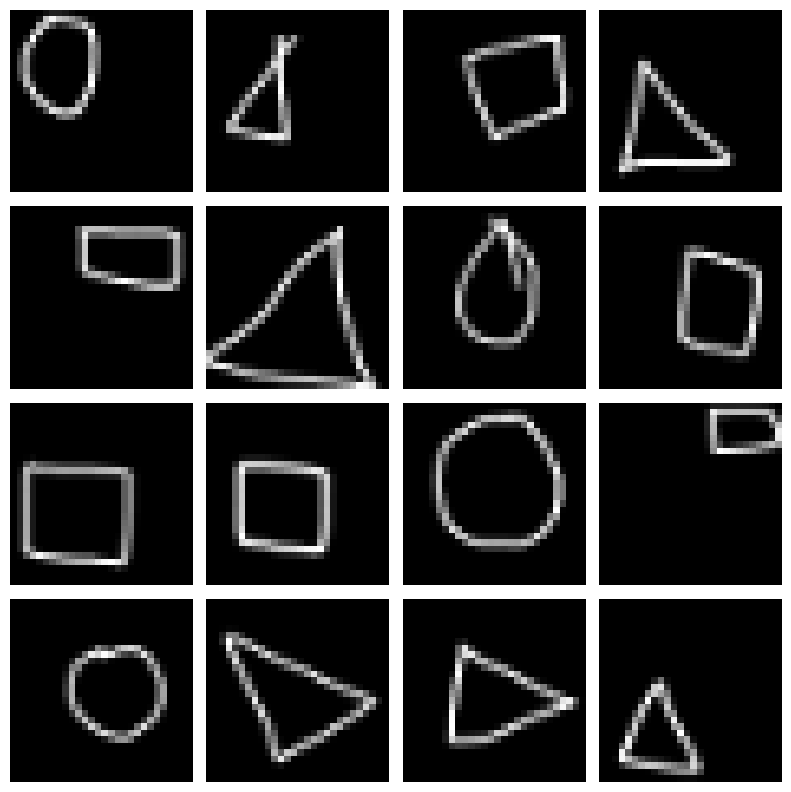

In [248]:
if DATA_SET == 'Shapes' :
    shapes, targets = load_shapes_dataset()
    shapes = 1 - shapes.reshape(-1, 1, 28, 28) / 255.
    print(shapes.shape)


    train_indeces = sample_indices(targets, k=90, seed=42)
    remaining_indeces = list(set(range(len(targets)))-set(train_indeces))
    test_indeces = sample_indices(targets[remaining_indeces], k=10, seed=42)
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))


elif DATA_SET == 'MNIST' :
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

    train_indeces = sample_indices(mnist_trainset.targets, k=50, seed=42)
    remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
    test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=5, seed=42)

    train_dataset = mnist_trainset.data[train_indeces].reshape(-1, 1, 28, 28) / 255.
    eval_dataset = mnist_trainset.data[test_indeces].reshape(-1, 1, 28, 28) / 255.

print(train_dataset.shape, eval_dataset.shape)
print(train_dataset.min(), train_dataset.max())

plot_grid(train_dataset)

In [249]:
# train_mean, train_std = train_dataset.mean(), train_dataset.std()
# train_dataset -= train_mean / train_std
# eval_dataset -= train_mean / train_std

# TRAIN

## Configure Training

In [250]:
from pythae.models import *
from pythae.models.nn.benchmarks.mnist import *
from pythae.models.nn.default_architectures import *
from pythae.models.base.base_utils import ModelOutput
from utils.models import Encoder_VAE_TinyMLP, Decoder_AE_TinyMLP

architecture_dict = {
    'tiny':
        {
        'encoder': Encoder_VAE_TinyMLP,
        'decoder': Decoder_AE_TinyMLP,
        },
    'mlp':
        {
        'encoder': Encoder_VAE_MLP,
        'decoder': Decoder_AE_MLP,
        },
    'convnet':
        {
        'encoder': Encoder_Conv_VAE_MNIST,
        'decoder': Decoder_Conv_AE_MNIST,
        },
    'resnet':
        {
        'encoder': Encoder_ResNet_VAE_MNIST,
        'decoder': Decoder_ResNet_AE_MNIST,
        },
    }


# model_config = RHVAEConfig(
#     input_dim=(1, 28, 28),
#     latent_dim=8,
#     reconstruction_loss="mse",
#     n_lf=3,
#     eps_lf=1e-3,
#     beta_zero=0.3,
#     temperature=0.8,
#     regularization=1e-2
# )

# model = RHVAE(
#     model_config=model_config,
#     encoder=architecture_dict['tiny']['encoder'](model_config),
#     decoder=architecture_dict['tiny']['decoder'](model_config),
# )

model_config = VAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=8,
)

model = VAE(
    model_config=model_config,
    encoder=architecture_dict['tiny']['encoder'](model_config),
    decoder=architecture_dict['tiny']['decoder'](model_config),
)

In [251]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

%time count_parameters(model)

CPU times: user 189 µs, sys: 7 µs, total: 196 µs
Wall time: 206 µs


638400

In [252]:
print(model)

VAE(
  (decoder): Decoder_AE_TinyMLP(
    (layers): Sequential(
      (0): Linear(in_features=8, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
  (encoder): Encoder_VAE_TinyMLP(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=400, bias=True)
      (2): ReLU()
    )
    (embedding): Linear(in_features=400, out_features=8, bias=True)
    (log_var): Linear(in_features=400, out_features=8, bias=True)
  )
)


## Early Stopping

In [253]:
from pytorch_lightning.callbacks import EarlyStopping
# early_stop_cb = EarlyStopping(
#     monitor='val_loss',
#     min_delta=1e-5,
#     patience=3,
#     verbose=False,
#     mode='min')

from pythae.trainers.training_callbacks import *

class EarlyStopping(TrainingCallback):
    def __init__(self, patience=5, min_delta=0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best_metric = np.Inf if mode == 'min' else -np.Inf
        self.counter = 0
        self.early_stop = False

    def on_eval_step_end(self, training_config: BaseTrainerConfig, **kwargs):
        logger = kwargs.pop("logger", self.logger)

        if logger is not None:
            current_metric = logger.get("eval_epoch_loss", None)

            if self.mode == 'min':
                improvement = current_metric < self.best_metric - self.min_delta
            else:
                improvement = current_metric > self.best_metric + self.min_delta

            if improvement:
                self.best_metric = current_metric
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True

            return self.early_stop

early_stop_cb = EarlyStopping(
    min_delta=10,
    patience=0,
    mode='min')

callbacks = []
callbacks.append(early_stop_cb)

## Train

In [254]:
from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.pipelines.training import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=200,
    learning_rate=1e-3,
    per_device_train_batch_size=len(train_dataset),
    per_device_eval_batch_size=len(eval_dataset),
    # optimizer_params={'weight_decay':1e-4},
    # scheduler_cls="ReduceLROnPlateau",
    # scheduler_params={"patience": 5, "factor": 0.5, "verbose": True}
)

pipeline = TrainingPipeline(
        training_config=training_config,
        model=model
)

if TRAIN_FLAG:
    pipeline(
        train_data=train_dataset,
        eval_data=eval_dataset,
        #callbacks=callbacks
    )
else:
    pass

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created experiments/VAE_training_2024-05-28_13-10-31. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 200
 - per_device_train_batch_size: 270
 - per_device_eval_batch_size: 30
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Scheduler: None

Successfully launched training !



Training of epoch 1/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 1/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 89.6771
Eval loss: 80.9015
--------------------------------------------------------------------------


Training of epoch 2/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 2/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 81.587
Eval loss: 73.3702
--------------------------------------------------------------------------


Training of epoch 3/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 3/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 73.6057
Eval loss: 66.4328
--------------------------------------------------------------------------


Training of epoch 4/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 4/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 66.8323
Eval loss: 57.5839
--------------------------------------------------------------------------


Training of epoch 5/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 5/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 59.0077
Eval loss: 52.9207
--------------------------------------------------------------------------


Training of epoch 6/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 6/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 52.408
Eval loss: 45.2503
--------------------------------------------------------------------------


Training of epoch 7/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 7/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 45.0363
Eval loss: 38.6933
--------------------------------------------------------------------------


Training of epoch 8/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 8/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.9583
Eval loss: 30.944
--------------------------------------------------------------------------


Training of epoch 9/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 9/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 31.401
Eval loss: 28.6613
--------------------------------------------------------------------------


Training of epoch 10/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 10/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.5086
Eval loss: 25.8249
--------------------------------------------------------------------------


Training of epoch 11/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 11/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 23.3622
Eval loss: 20.4467
--------------------------------------------------------------------------


Training of epoch 12/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 12/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 20.7071
Eval loss: 22.2478
--------------------------------------------------------------------------


Training of epoch 13/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 13/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 20.1817
Eval loss: 21.1036
--------------------------------------------------------------------------


Training of epoch 14/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 14/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 19.8515
Eval loss: 19.9149
--------------------------------------------------------------------------


Training of epoch 15/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 15/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 19.3386
Eval loss: 20.3229
--------------------------------------------------------------------------


Training of epoch 16/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 16/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 18.8495
Eval loss: 17.3596
--------------------------------------------------------------------------


Training of epoch 17/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 17/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 17.8176
Eval loss: 17.2518
--------------------------------------------------------------------------


Training of epoch 18/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 18/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 16.9374
Eval loss: 15.3695
--------------------------------------------------------------------------


Training of epoch 19/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 19/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 15.3638
Eval loss: 14.6862
--------------------------------------------------------------------------


Training of epoch 20/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 20/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 14.7587
Eval loss: 14.008
--------------------------------------------------------------------------


Training of epoch 21/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 21/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 13.6555
Eval loss: 13.0774
--------------------------------------------------------------------------


Training of epoch 22/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 22/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 13.4261
Eval loss: 12.6832
--------------------------------------------------------------------------


Training of epoch 23/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 23/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 12.7054
Eval loss: 12.4296
--------------------------------------------------------------------------


Training of epoch 24/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 24/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 12.7782
Eval loss: 13.0421
--------------------------------------------------------------------------


Training of epoch 25/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 25/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 12.5874
Eval loss: 12.0406
--------------------------------------------------------------------------


Training of epoch 26/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 26/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 12.4823
Eval loss: 12.3062
--------------------------------------------------------------------------


Training of epoch 27/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 27/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 12.0495
Eval loss: 12.3407
--------------------------------------------------------------------------


Training of epoch 28/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 28/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 11.8441
Eval loss: 11.9633
--------------------------------------------------------------------------


Training of epoch 29/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 29/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 12.0516
Eval loss: 13.2207
--------------------------------------------------------------------------


Training of epoch 30/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 30/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 12.0571
Eval loss: 12.0408
--------------------------------------------------------------------------


Training of epoch 31/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 31/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 11.9111
Eval loss: 11.2301
--------------------------------------------------------------------------


Training of epoch 32/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 32/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 11.7939
Eval loss: 12.2705
--------------------------------------------------------------------------


Training of epoch 33/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 33/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 11.2925
Eval loss: 11.1381
--------------------------------------------------------------------------


Training of epoch 34/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 34/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 11.317
Eval loss: 11.7968
--------------------------------------------------------------------------


Training of epoch 35/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 35/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 11.0796
Eval loss: 11.5508
--------------------------------------------------------------------------


Training of epoch 36/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 36/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 11.3008
Eval loss: 11.5441
--------------------------------------------------------------------------


Training of epoch 37/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 37/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 11.0704
Eval loss: 10.9005
--------------------------------------------------------------------------


Training of epoch 38/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 38/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 11.1599
Eval loss: 11.4591
--------------------------------------------------------------------------


Training of epoch 39/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 39/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 11.1516
Eval loss: 10.4886
--------------------------------------------------------------------------


Training of epoch 40/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 40/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 11.0539
Eval loss: 11.0693
--------------------------------------------------------------------------


Training of epoch 41/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 41/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.8731
Eval loss: 10.7204
--------------------------------------------------------------------------


Training of epoch 42/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 42/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.8016
Eval loss: 10.9136
--------------------------------------------------------------------------


Training of epoch 43/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 43/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.591
Eval loss: 11.006
--------------------------------------------------------------------------


Training of epoch 44/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 44/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.6132
Eval loss: 10.1586
--------------------------------------------------------------------------


Training of epoch 45/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 45/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5198
Eval loss: 10.8227
--------------------------------------------------------------------------


Training of epoch 46/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 46/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.5417
Eval loss: 10.4112
--------------------------------------------------------------------------


Training of epoch 47/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 47/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.4001
Eval loss: 10.4921
--------------------------------------------------------------------------


Training of epoch 48/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 48/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.4633
Eval loss: 10.9476
--------------------------------------------------------------------------


Training of epoch 49/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 49/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.4724
Eval loss: 10.1879
--------------------------------------------------------------------------


Training of epoch 50/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 50/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.2961
Eval loss: 10.2935
--------------------------------------------------------------------------


Training of epoch 51/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 51/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.3565
Eval loss: 10.0831
--------------------------------------------------------------------------


Training of epoch 52/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 52/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.3823
Eval loss: 10.3321
--------------------------------------------------------------------------


Training of epoch 53/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 53/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.4235
Eval loss: 10.5036
--------------------------------------------------------------------------


Training of epoch 54/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 54/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.4567
Eval loss: 10.3614
--------------------------------------------------------------------------


Training of epoch 55/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 55/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.1828
Eval loss: 10.3172
--------------------------------------------------------------------------


Training of epoch 56/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 56/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.1124
Eval loss: 10.5089
--------------------------------------------------------------------------


Training of epoch 57/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 57/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.1961
Eval loss: 10.8616
--------------------------------------------------------------------------


Training of epoch 58/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 58/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.0608
Eval loss: 10.0392
--------------------------------------------------------------------------


Training of epoch 59/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 59/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.1318
Eval loss: 10.0485
--------------------------------------------------------------------------


Training of epoch 60/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 60/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.1171
Eval loss: 10.3222
--------------------------------------------------------------------------


Training of epoch 61/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 61/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.0581
Eval loss: 10.6262
--------------------------------------------------------------------------


Training of epoch 62/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 62/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.9609
Eval loss: 10.1554
--------------------------------------------------------------------------


Training of epoch 63/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 63/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 10.0439
Eval loss: 10.3319
--------------------------------------------------------------------------


Training of epoch 64/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 64/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.9535
Eval loss: 10.2791
--------------------------------------------------------------------------


Training of epoch 65/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 65/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.8802
Eval loss: 10.3516
--------------------------------------------------------------------------


Training of epoch 66/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 66/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.9456
Eval loss: 10.1853
--------------------------------------------------------------------------


Training of epoch 67/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 67/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.8158
Eval loss: 10.0393
--------------------------------------------------------------------------


Training of epoch 68/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 68/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.9272
Eval loss: 10.0897
--------------------------------------------------------------------------


Training of epoch 69/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 69/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.7883
Eval loss: 10.2822
--------------------------------------------------------------------------


Training of epoch 70/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 70/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.8312
Eval loss: 9.6885
--------------------------------------------------------------------------


Training of epoch 71/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 71/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.9112
Eval loss: 10.0448
--------------------------------------------------------------------------


Training of epoch 72/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 72/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.9359
Eval loss: 9.9334
--------------------------------------------------------------------------


Training of epoch 73/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 73/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.7353
Eval loss: 9.8695
--------------------------------------------------------------------------


Training of epoch 74/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 74/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.8496
Eval loss: 10.5834
--------------------------------------------------------------------------


Training of epoch 75/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 75/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.805
Eval loss: 9.7728
--------------------------------------------------------------------------


Training of epoch 76/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 76/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.8433
Eval loss: 9.8769
--------------------------------------------------------------------------


Training of epoch 77/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 77/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.7642
Eval loss: 10.05
--------------------------------------------------------------------------


Training of epoch 78/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 78/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.7468
Eval loss: 9.5476
--------------------------------------------------------------------------


Training of epoch 79/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 79/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.6933
Eval loss: 9.8849
--------------------------------------------------------------------------


Training of epoch 80/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 80/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.7723
Eval loss: 9.6215
--------------------------------------------------------------------------


Training of epoch 81/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 81/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.6347
Eval loss: 10.1085
--------------------------------------------------------------------------


Training of epoch 82/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 82/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.84
Eval loss: 9.7268
--------------------------------------------------------------------------


Training of epoch 83/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 83/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.6339
Eval loss: 10.0742
--------------------------------------------------------------------------


Training of epoch 84/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 84/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.7514
Eval loss: 9.6771
--------------------------------------------------------------------------


Training of epoch 85/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 85/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.7189
Eval loss: 9.6928
--------------------------------------------------------------------------


Training of epoch 86/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 86/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.6755
Eval loss: 9.6826
--------------------------------------------------------------------------


Training of epoch 87/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 87/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.5648
Eval loss: 10.0943
--------------------------------------------------------------------------


Training of epoch 88/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 88/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.6109
Eval loss: 9.9824
--------------------------------------------------------------------------


Training of epoch 89/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 89/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.6357
Eval loss: 9.7843
--------------------------------------------------------------------------


Training of epoch 90/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 90/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.5032
Eval loss: 9.7522
--------------------------------------------------------------------------


Training of epoch 91/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 91/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.5907
Eval loss: 9.7347
--------------------------------------------------------------------------


Training of epoch 92/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 92/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.5523
Eval loss: 9.806
--------------------------------------------------------------------------


Training of epoch 93/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 93/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.6543
Eval loss: 9.9699
--------------------------------------------------------------------------


Training of epoch 94/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 94/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.5728
Eval loss: 10.1896
--------------------------------------------------------------------------


Training of epoch 95/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 95/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4881
Eval loss: 9.6379
--------------------------------------------------------------------------


Training of epoch 96/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 96/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4951
Eval loss: 9.6032
--------------------------------------------------------------------------


Training of epoch 97/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 97/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.6416
Eval loss: 9.6925
--------------------------------------------------------------------------


Training of epoch 98/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 98/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.5262
Eval loss: 9.4843
--------------------------------------------------------------------------


Training of epoch 99/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 99/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.614
Eval loss: 9.4563
--------------------------------------------------------------------------


Training of epoch 100/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 100/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.5235
Eval loss: 10.0997
--------------------------------------------------------------------------


Training of epoch 101/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 101/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4802
Eval loss: 9.5591
--------------------------------------------------------------------------


Training of epoch 102/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 102/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.5996
Eval loss: 9.7161
--------------------------------------------------------------------------


Training of epoch 103/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 103/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.6107
Eval loss: 10.0283
--------------------------------------------------------------------------


Training of epoch 104/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 104/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4717
Eval loss: 10.1326
--------------------------------------------------------------------------


Training of epoch 105/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 105/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.5695
Eval loss: 9.7199
--------------------------------------------------------------------------


Training of epoch 106/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 106/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4246
Eval loss: 9.7903
--------------------------------------------------------------------------


Training of epoch 107/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 107/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.5375
Eval loss: 9.6088
--------------------------------------------------------------------------


Training of epoch 108/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 108/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.473
Eval loss: 9.7804
--------------------------------------------------------------------------


Training of epoch 109/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 109/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.5653
Eval loss: 9.5735
--------------------------------------------------------------------------


Training of epoch 110/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 110/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.5395
Eval loss: 9.559
--------------------------------------------------------------------------


Training of epoch 111/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 111/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.5099
Eval loss: 9.5767
--------------------------------------------------------------------------


Training of epoch 112/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 112/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4911
Eval loss: 10.1223
--------------------------------------------------------------------------


Training of epoch 113/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 113/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3524
Eval loss: 10.1007
--------------------------------------------------------------------------


Training of epoch 114/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 114/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4161
Eval loss: 9.8431
--------------------------------------------------------------------------


Training of epoch 115/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 115/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3892
Eval loss: 9.5845
--------------------------------------------------------------------------


Training of epoch 116/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 116/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.5725
Eval loss: 9.7506
--------------------------------------------------------------------------


Training of epoch 117/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 117/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4492
Eval loss: 9.5974
--------------------------------------------------------------------------


Training of epoch 118/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 118/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3699
Eval loss: 9.5534
--------------------------------------------------------------------------


Training of epoch 119/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 119/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4599
Eval loss: 9.4755
--------------------------------------------------------------------------


Training of epoch 120/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 120/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4264
Eval loss: 9.5885
--------------------------------------------------------------------------


Training of epoch 121/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 121/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3505
Eval loss: 9.5407
--------------------------------------------------------------------------


Training of epoch 122/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 122/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3883
Eval loss: 9.5878
--------------------------------------------------------------------------


Training of epoch 123/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 123/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4906
Eval loss: 9.8315
--------------------------------------------------------------------------


Training of epoch 124/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 124/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.5122
Eval loss: 9.5922
--------------------------------------------------------------------------


Training of epoch 125/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 125/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4627
Eval loss: 9.6164
--------------------------------------------------------------------------


Training of epoch 126/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 126/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3965
Eval loss: 9.6304
--------------------------------------------------------------------------


Training of epoch 127/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 127/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4233
Eval loss: 9.5861
--------------------------------------------------------------------------


Training of epoch 128/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 128/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4103
Eval loss: 9.5417
--------------------------------------------------------------------------


Training of epoch 129/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 129/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3477
Eval loss: 9.5496
--------------------------------------------------------------------------


Training of epoch 130/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 130/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4401
Eval loss: 9.7683
--------------------------------------------------------------------------


Training of epoch 131/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 131/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.384
Eval loss: 9.7104
--------------------------------------------------------------------------


Training of epoch 132/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 132/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3516
Eval loss: 9.4831
--------------------------------------------------------------------------


Training of epoch 133/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 133/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3885
Eval loss: 9.6251
--------------------------------------------------------------------------


Training of epoch 134/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 134/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4729
Eval loss: 9.5348
--------------------------------------------------------------------------


Training of epoch 135/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 135/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3906
Eval loss: 9.7944
--------------------------------------------------------------------------


Training of epoch 136/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 136/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4251
Eval loss: 9.3635
--------------------------------------------------------------------------


Training of epoch 137/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 137/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3157
Eval loss: 9.5661
--------------------------------------------------------------------------


Training of epoch 138/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 138/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.504
Eval loss: 9.44
--------------------------------------------------------------------------


Training of epoch 139/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 139/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4583
Eval loss: 9.5068
--------------------------------------------------------------------------


Training of epoch 140/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 140/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3676
Eval loss: 9.4672
--------------------------------------------------------------------------


Training of epoch 141/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 141/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3808
Eval loss: 9.5057
--------------------------------------------------------------------------


Training of epoch 142/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 142/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3446
Eval loss: 9.4923
--------------------------------------------------------------------------


Training of epoch 143/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 143/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3964
Eval loss: 9.4444
--------------------------------------------------------------------------


Training of epoch 144/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 144/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2957
Eval loss: 9.7756
--------------------------------------------------------------------------


Training of epoch 145/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 145/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4478
Eval loss: 9.4811
--------------------------------------------------------------------------


Training of epoch 146/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 146/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3481
Eval loss: 9.4733
--------------------------------------------------------------------------


Training of epoch 147/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 147/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3943
Eval loss: 9.6258
--------------------------------------------------------------------------


Training of epoch 148/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 148/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.351
Eval loss: 9.7231
--------------------------------------------------------------------------


Training of epoch 149/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 149/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4266
Eval loss: 9.5121
--------------------------------------------------------------------------


Training of epoch 150/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 150/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3671
Eval loss: 9.569
--------------------------------------------------------------------------


Training of epoch 151/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 151/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3844
Eval loss: 9.479
--------------------------------------------------------------------------


Training of epoch 152/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 152/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3472
Eval loss: 9.7841
--------------------------------------------------------------------------


Training of epoch 153/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 153/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3342
Eval loss: 9.5342
--------------------------------------------------------------------------


Training of epoch 154/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 154/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.304
Eval loss: 9.5394
--------------------------------------------------------------------------


Training of epoch 155/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 155/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3341
Eval loss: 9.528
--------------------------------------------------------------------------


Training of epoch 156/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 156/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3517
Eval loss: 9.5815
--------------------------------------------------------------------------


Training of epoch 157/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 157/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2977
Eval loss: 9.4336
--------------------------------------------------------------------------


Training of epoch 158/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 158/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3531
Eval loss: 9.5056
--------------------------------------------------------------------------


Training of epoch 159/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 159/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3136
Eval loss: 9.5107
--------------------------------------------------------------------------


Training of epoch 160/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 160/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3633
Eval loss: 9.6708
--------------------------------------------------------------------------


Training of epoch 161/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 161/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2755
Eval loss: 9.4098
--------------------------------------------------------------------------


Training of epoch 162/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 162/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2923
Eval loss: 9.4907
--------------------------------------------------------------------------


Training of epoch 163/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 163/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3074
Eval loss: 9.4467
--------------------------------------------------------------------------


Training of epoch 164/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 164/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2481
Eval loss: 9.3991
--------------------------------------------------------------------------


Training of epoch 165/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 165/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2779
Eval loss: 9.4247
--------------------------------------------------------------------------


Training of epoch 166/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 166/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2497
Eval loss: 9.3759
--------------------------------------------------------------------------


Training of epoch 167/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 167/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2791
Eval loss: 9.5323
--------------------------------------------------------------------------


Training of epoch 168/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 168/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3075
Eval loss: 9.369
--------------------------------------------------------------------------


Training of epoch 169/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 169/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2811
Eval loss: 9.4108
--------------------------------------------------------------------------


Training of epoch 170/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 170/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3092
Eval loss: 9.6004
--------------------------------------------------------------------------


Training of epoch 171/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 171/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3723
Eval loss: 9.4901
--------------------------------------------------------------------------


Training of epoch 172/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 172/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.31
Eval loss: 9.4723
--------------------------------------------------------------------------


Training of epoch 173/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 173/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2755
Eval loss: 9.3491
--------------------------------------------------------------------------


Training of epoch 174/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 174/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2691
Eval loss: 9.4747
--------------------------------------------------------------------------


Training of epoch 175/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 175/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3007
Eval loss: 9.5497
--------------------------------------------------------------------------


Training of epoch 176/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 176/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3026
Eval loss: 9.5389
--------------------------------------------------------------------------


Training of epoch 177/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 177/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.4198
Eval loss: 9.3617
--------------------------------------------------------------------------


Training of epoch 178/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 178/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2791
Eval loss: 9.5129
--------------------------------------------------------------------------


Training of epoch 179/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 179/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2902
Eval loss: 9.6457
--------------------------------------------------------------------------


Training of epoch 180/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 180/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2724
Eval loss: 9.524
--------------------------------------------------------------------------


Training of epoch 181/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 181/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2776
Eval loss: 9.4376
--------------------------------------------------------------------------


Training of epoch 182/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 182/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3541
Eval loss: 9.4939
--------------------------------------------------------------------------


Training of epoch 183/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 183/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2938
Eval loss: 9.3872
--------------------------------------------------------------------------


Training of epoch 184/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 184/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2755
Eval loss: 9.291
--------------------------------------------------------------------------


Training of epoch 185/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 185/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2734
Eval loss: 9.4108
--------------------------------------------------------------------------


Training of epoch 186/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 186/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2542
Eval loss: 9.5704
--------------------------------------------------------------------------


Training of epoch 187/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 187/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2164
Eval loss: 9.533
--------------------------------------------------------------------------


Training of epoch 188/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 188/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3323
Eval loss: 9.8569
--------------------------------------------------------------------------


Training of epoch 189/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 189/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2228
Eval loss: 9.5432
--------------------------------------------------------------------------


Training of epoch 190/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 190/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2364
Eval loss: 9.4701
--------------------------------------------------------------------------


Training of epoch 191/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 191/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.243
Eval loss: 9.4038
--------------------------------------------------------------------------


Training of epoch 192/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 192/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2615
Eval loss: 9.3217
--------------------------------------------------------------------------


Training of epoch 193/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 193/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.382
Eval loss: 9.5098
--------------------------------------------------------------------------


Training of epoch 194/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 194/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2375
Eval loss: 9.512
--------------------------------------------------------------------------


Training of epoch 195/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 195/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2581
Eval loss: 9.6507
--------------------------------------------------------------------------


Training of epoch 196/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 196/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.203
Eval loss: 9.4997
--------------------------------------------------------------------------


Training of epoch 197/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 197/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3144
Eval loss: 9.4616
--------------------------------------------------------------------------


Training of epoch 198/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 198/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2276
Eval loss: 9.6188
--------------------------------------------------------------------------


Training of epoch 199/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 199/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.3075
Eval loss: 9.4828
--------------------------------------------------------------------------


Training of epoch 200/200:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 200/200:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 9.2256
Eval loss: 9.4139
--------------------------------------------------------------------------
Training ended!
Saved final model in experiments/VAE_training_2024-05-28_13-10-31/final_model


## Trained Model

In [255]:
from pythae.models import AutoModel

import glob

if TRAIN_FLAG:
    trained_model = model
else:
    trained_model = AutoModel.load_from_folder(glob.glob('experiments/*/final_model')[0])

# RECONSTRUCTIONS

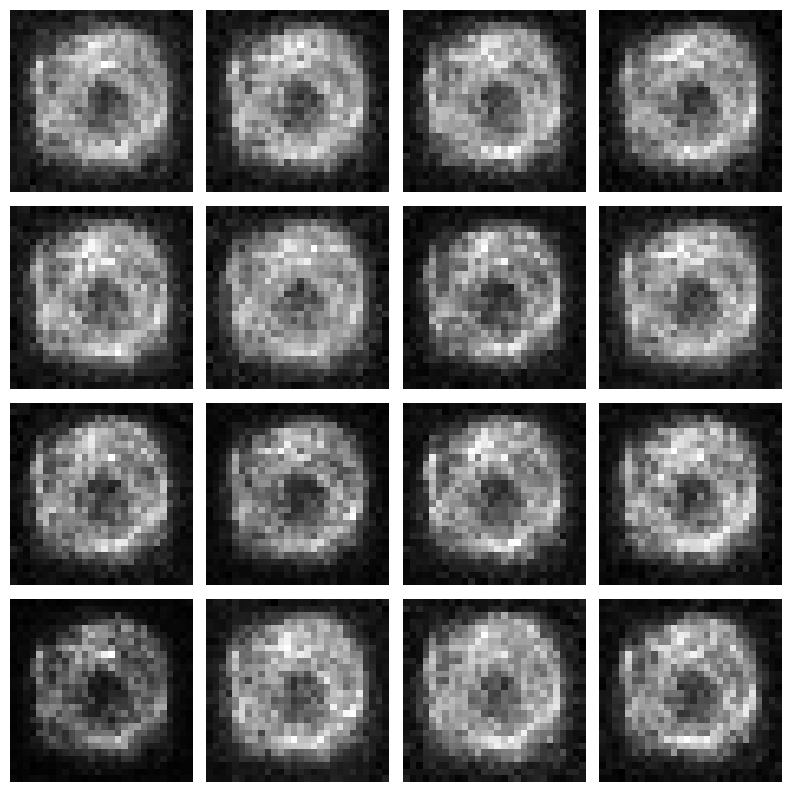

In [256]:
reconstructions = trained_model.reconstruct(eval_dataset[:25]).detach().cpu()

# # show reconstructions
# fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

# for i in range(5):
#     for j in range(5):
#         axes[i][j].imshow(reconstructions[i*5 + j].cpu().squeeze(0), cmap='gray')
#         axes[i][j].axis('off')
# plt.tight_layout(pad=0.)
plot_grid(reconstructions)

In [257]:
eval_dataset[:25].shape

torch.Size([25, 1, 28, 28])

# INTERPOLATIONS

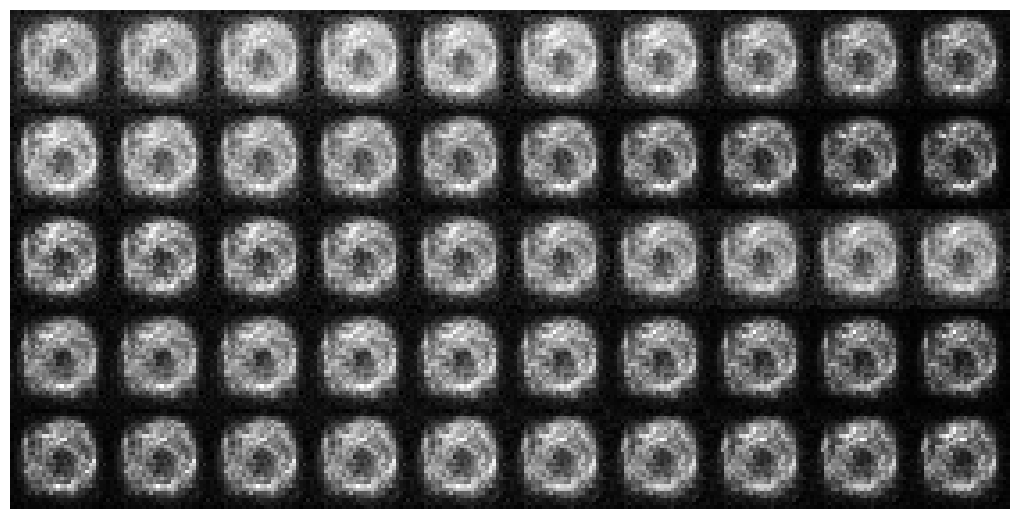

In [258]:
interpolations = trained_model.interpolate(eval_dataset[:5], eval_dataset[5:10], granularity=10).detach().cpu()

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(10):
        axes[i][j].imshow(interpolations[i, j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

# GENERATE

### Normal Sampler

In [259]:
from pythae.samplers import NormalSampler


sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=25,
)

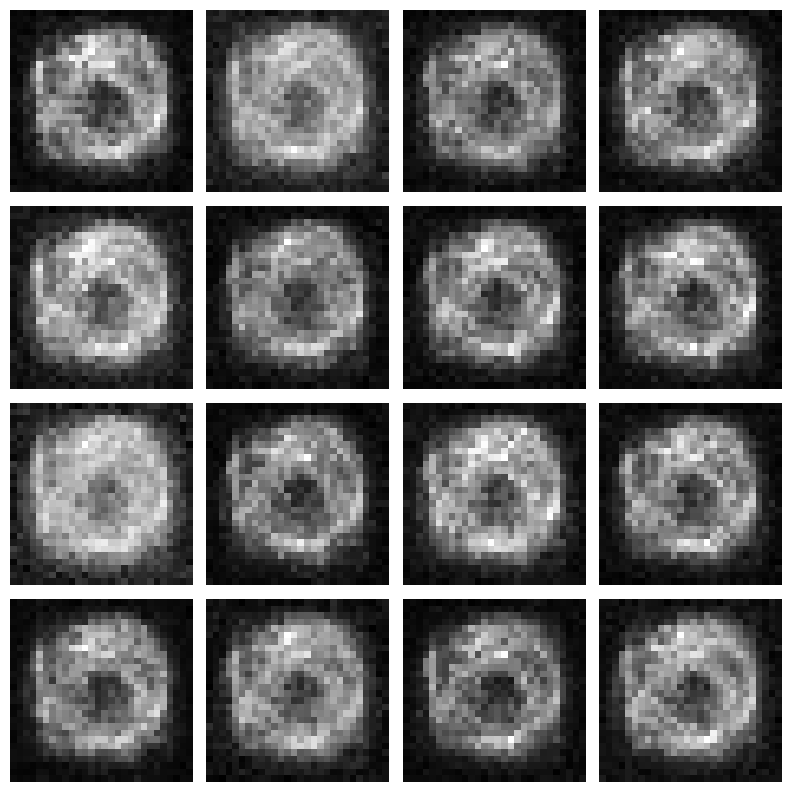

In [260]:
plot_grid(gen_data.data)

### Gaussian Mixture Model Sampler

In [261]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=10
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_dataset
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=25
)

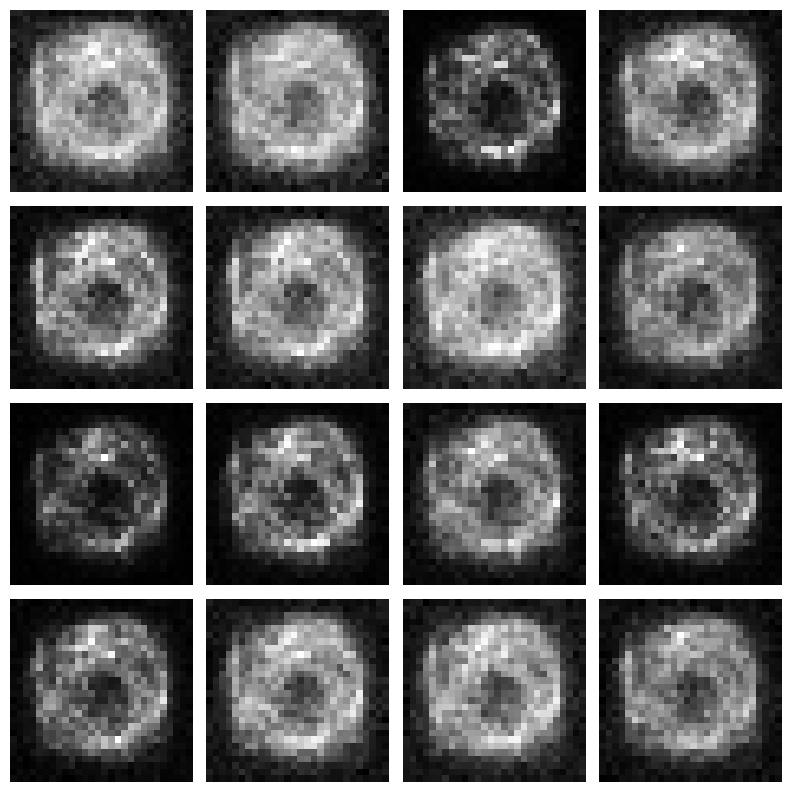

In [262]:
plot_grid(gmm_gen_data.data)

### RHVAE Sampler

In [263]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig


rh_sampler_config = RHVAESamplerConfig(
    # mcmc_steps_nbr = 200,
    # n_lf = 3,
    # eps_lf = 1e-3,
    # beta_zero = 0.3
)

rh_sampler = RHVAESampler(
    sampler_config=rh_sampler_config,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset
)

rh_gen_data = rh_sampler.sample(
   num_samples=25
)

AttributeError: 'VAE' object has no attribute 'M_tens'

In [ ]:
plot_grid(rh_gen_data)

In [ ]:
rh_gen_data.shape

In [ ]:
# #combined_dataset = ConcatDataset([train_dataset, rh_gen_data])
# combined_dataset = torch.cat((train_dataset, rh_gen_data), 0)
# combined_dataset = combined_dataset[torch.randperm(combined_dataset.size()[0])]
# combined_dataset.shape